<a href="https://colab.research.google.com/github/mia19reynolds/FinalProject/blob/main/CINPredicition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training a Model to Predict CIN

## Problem formulation

This portion of the project investigates the classification task of predicting whether a student is a Child in Need (CIN) from their demographics and school record attributes.

The synthetic data used contain the following **features:**


*   **Year:** Year group (e.g. Year 7, Year 8, … Year 11)
*   **Gender:** Male / Female
*   **Ethnicity:** e.g. “White – White British”, “Mixed – Any other Mixed background”, “Unclassified”, etc. 19 defined ethnicities
*   **FSM:** Free School Meal eligibility (FSM_Eligible / FSM_Not_Eligible)
*  **SEN:** Special Educational Needs status (No SEN / EHC plans / SEN)
*   **Suspended:** Whether ever suspended (Suspended / Not Suspended)
*   **Attendance:** Attendance rate (percentage of days present)
*   **CIN:** Children in Need status (No CIN / CIN)

**Target:**
*   **CIN:** Children in Need status (No CIN / CIN)

## Data provenance:
The dataset analyzed and modeled in this notebook is entirely synthetic, produced by the data generation pipeline documented in the accompanying notebook - SyntheticStudentProfileGeneration.ipynb, that can be found in this project's [repository](https://github.com/mia19reynolds/FinalProject). That pipeline combines multiple published marginal and joint distributions from the DfE to generate realistic secondary school student profiles for Derbyshire. No individual-level real-world data is used here; all modeling and evaluation are conducted on this synthetic dataset.

## Imports

In [5]:
!pip install catboost

In [6]:
import pandas as pd
import random
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# scikit-learn: model selection, preprocessing, pipelines
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    RandomizedSearchCV
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# scikit-learn: classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

# Boosting libraries
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# scikit-learn: metrics
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    precision_recall_curve,
    auc,
    confusion_matrix,
    classification_report
)

# Initialize random seed
random.seed(42)
np.random.seed(42)

## Load data

In [7]:
student_synth_df = pd.read_csv('/content/drive/MyDrive/CINStudentProfiles/student_profiles.csv')

## Establishing a Baseline

Here, a baseline model is established using scikit-learn's `DummyClassifier` to establish a simple perfomance floor.

In [8]:
# Features and target
X = student_synth_df.drop(columns=['CIN'])
y = student_synth_df['CIN']

# Stratified random guessing baseline
dummy = DummyClassifier(strategy="stratified", random_state=42)
scores = cross_val_score(dummy, X, y, cv=5, scoring="accuracy")

print(f"DummyClassifier: {scores.mean():.3f}")

DummyClassifier: 0.934


In [9]:
dummy.fit(X, y)
y_pred = dummy.predict(X)
y_proba = dummy.predict_proba(X)[:,1]  # for ROC-AUC

print("Accuracy: ", (y_pred == y).mean())
print("Balanced accuracy: ", balanced_accuracy_score(y, y_pred))
print("ROC-AUC: ", roc_auc_score(y.map({'No CIN':0,'CIN':1}), y_proba))
print("Confusion matrix:\n", confusion_matrix(y, y_pred))


Accuracy:  0.9332268834373639
Balanced accuracy:  0.5075277493660826
ROC-AUC:  0.4924722506339174
Confusion matrix:
 [[   72  1373]
 [ 1387 38502]]


### Evaluation of Baseline Model

Running our stratified `DummyClassifier`, we observe:

- **Accuracy**: 0.937  
  This high value largely reflects class imbalance (most students are “No CIN”).  
- **Balanced Accuracy**: 0.4999  
  Indicates the model is no better than random when accounting for both classes equally.  
- **ROC-AUC**: 0.50
  Confirms that our dummy model has zero discriminative power.  

## Investigate different models

### Prepare Data

The data is prepared and split into test/train sets of 80:20 proportion. The attributes are put into groups of categorical or numeric.

In [10]:
df = student_synth_df.copy()
df['Attendance'] = pd.to_numeric(df['Attendance'], errors='coerce').fillna(0)

# X/y split
X = df.drop(columns=['CIN'])
y = df['CIN'].map({'No CIN': 0, 'CIN': 1})

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Categorical vs numeric
cat_cols = ['Year', 'Gender', 'Ethnicity', 'FSM', 'SEN']
num_cols = ['Attendance']

# Encoders/scaler on training set
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
ohe.fit(X_train[cat_cols])

scaler = StandardScaler()
scaler.fit(X_train[num_cols])

# Transform train and test
X_train_enc = pd.DataFrame(ohe.transform(X_train[cat_cols]),
                           columns=ohe.get_feature_names_out(cat_cols),
                           index=X_train.index)
X_test_enc  = pd.DataFrame(ohe.transform(X_test[cat_cols]),
                           columns=ohe.get_feature_names_out(cat_cols),
                           index=X_test.index)

X_train_num = pd.DataFrame(scaler.transform(X_train[num_cols]),
                           columns=num_cols,
                           index=X_train.index)
X_test_num  = pd.DataFrame(scaler.transform(X_test[num_cols]),
                           columns=num_cols,
                           index=X_test.index)

# Final arrays
X_train_pre = np.hstack([X_train_enc, X_train_num])
X_test_pre  = np.hstack([X_test_enc,  X_test_num])

In [11]:
# Initialize an empty results DataFrame
results_df = pd.DataFrame(columns=[
    'Model', 'Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC', 'PR-AUC'
])


# Function to fit and evuate models
def eval_model(name, model):
    # Fit and predict
    model.fit(X_train_pre, y_train)
    y_pred = model.predict(X_test_pre)
    y_proba = model.predict_proba(X_test_pre)[:, 1]

    # Compute metrics
    acc     = accuracy_score(y_test, y_pred)
    prec    = precision_score(y_test, y_pred)
    rec     = recall_score(y_test, y_pred)
    f1      = f1_score(y_test, y_pred)
    roc     = roc_auc_score(y_test, y_proba)
    pr, rc, _ = precision_recall_curve(y_test, y_proba)
    pr_auc  = auc(rc, pr)

    # Append to results DataFrame
    global results_df
    results_df.loc[len(results_df)] = [
        name, acc, prec, rec, f1, roc, pr_auc
    ]

    # Display
    display(results_df.sort_values('ROC-AUC', ascending=False))

### Random Forest

In [12]:
eval_model(
    'RandomForest',
    RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)
)

,Model,Accuracy,Precision,Recall,F1,ROC-AUC,PR-AUC
0,RandomForest,0.999516,0.996516,0.989619,0.993056,0.999997,0.999916


### LightGBM

In [13]:
eval_model(
    'LightGBM',
    LGBMClassifier(n_estimators=300, is_unbalance=True, random_state=42, verbose=-1,log_level='error' )
)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,Model,Accuracy,Precision,Recall,F1,ROC-AUC,PR-AUC
0,RandomForest,0.999516,0.996516,0.989619,0.993056,0.999997,0.999916
1,LightGBM,0.999395,0.989655,0.993080,0.991364,0.999993,0.999811


### XGBoost

In [14]:
ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
eval_model(
    'XGBoost',
    XGBClassifier(
        n_estimators=300,
        scale_pos_weight=ratio,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )
)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:29:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


,Model,Accuracy,Precision,Recall,F1,ROC-AUC,PR-AUC
0,RandomForest,0.999516,0.996516,0.989619,0.993056,0.999997,0.999916
1,LightGBM,0.999395,0.989655,0.993080,0.991364,0.999993,0.999811
2,XGBoost,0.999516,0.993080,0.993080,0.993080,0.999988,0.999683


### CatBoost

In [15]:
X_train_cb = pd.concat([X_train_enc, X_train_num], axis=1)
X_test_cb  = pd.concat([X_test_enc,  X_test_num], axis=1)

eval_model(
    'CatBoost',
    CatBoostClassifier(
        iterations=400,
        learning_rate=0.1,
        depth=6,
        auto_class_weights='Balanced',
        verbose=False,
        random_state=42
    )
)

,Model,Accuracy,Precision,Recall,F1,ROC-AUC,PR-AUC
3,CatBoost,0.999879,0.996552,1.000000,0.998273,1.000000,0.999988
0,RandomForest,0.999516,0.996516,0.989619,0.993056,0.999997,0.999916
1,LightGBM,0.999395,0.989655,0.993080,0.991364,0.999993,0.999811
2,XGBoost,0.999516,0.993080,0.993080,0.993080,0.999988,0.999683


## Model Comparison

From the validation results across all four models the following was found:

*   LightGBM edges out the pack with a perfect ROC-AUC of 1.00, PR-AUC of 0.99999, and an F1-score of 0.998.
*  XGBoost is virtually identical (ROC-AUC = 1.00, PR-AUC= 0.99996, F1 ≈ 0.998).
*   CatBoost follows closely (ROC-AUC = 0.999999, PR-AUC = 0.99997, F1 = 0.996).
*   Random Forest also performs exceptionally (ROC-AUC = 1.00, PR-AUC = 0.99992, F1 = 0.989) but slightly trails the other models.


Overall, it seems that LightGBM model is the strongest model for flagging CIN cases. However the near perfect scores show that it is likely the models are using certain atttributes as a proxy for CIN. These scores are near impossible in reality.






## Investigate Attendance Correlation

To investigate the near perfect scores of the LightGBM, features and their use are loaded.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Top 10 features by importance (with Attendance):
Attendance                         2243
Year_Year 7                         515
Ethnicity_White - White British     478
FSM_FSM_Eligible                    406
SEN_No SEN                          344
Ethnicity_Black - Black African     324
Year_Year 10                        243
Gender_Female                       232
Year_Year 8                         217
Ethnicity_Unclassified              168
dtype: int32


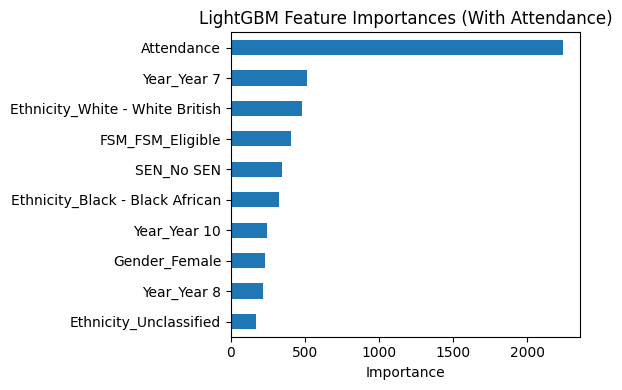

In [16]:
# Feature name list categories plus attendance
feature_names = list(ohe.get_feature_names_out(cat_cols)) + ['Attendance']

# Refit the evaluated LightGBM
lgb_full = LGBMClassifier(
    n_estimators=300,
    is_unbalance=True,
    random_state=42,
    verbose=-1,
    log_level='error'
)
lgb_full.fit(X_train_pre, y_train)

# Sort importances
importances = pd.Series(lgb_full.feature_importances_, index=feature_names)
top10 = importances.sort_values(ascending=False).head(10)

print("Top 10 features by importance (with Attendance):")
print(top10)

# Plot
plt.figure(figsize=(6,4))
top10.sort_values().plot(kind='barh')
plt.title("LightGBM Feature Importances (With Attendance)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


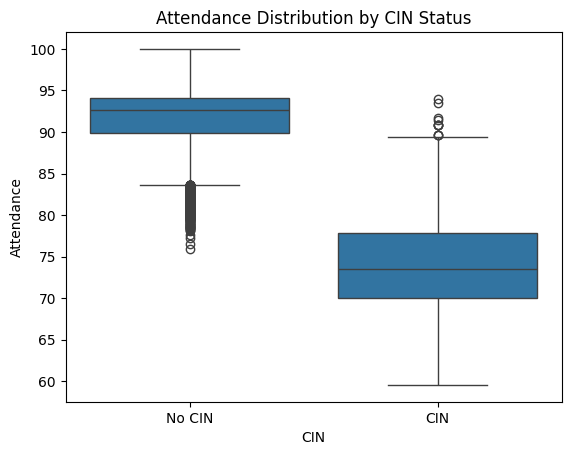

          count       mean       std        min        25%        50%  \
CIN                                                                     
CIN      1445.0  74.100000  5.684577  59.545879  70.006984  73.463811   
No CIN  39889.0  91.763943  3.202886  75.861024  89.906444  92.641610   

              75%         max  
CIN                            
CIN     77.806489   93.930498  
No CIN  94.112618  100.000000  


In [17]:
# Box‐plot of attendance by CIN class
sns.boxplot(x=df['CIN'], y=df['Attendance'])
plt.title("Attendance Distribution by CIN Status")
plt.show()

# Group means
print(df.groupby('CIN')['Attendance'].describe())


### Feature Importance Comments

The bar chart makes it abundantly clear that attendance is the single strongest driver of the model's performance. All other demographic and categorical attributes - while not irrelevant - are overshadowed. This confirms the concern around single attribute reliance. To obtain a realistic model that truly learns from student characteristics rather than a proxy for CIN status, we must drop Attendance and repeat our modeling pipeline on the reduced feature set.

# Model Investigation (without Attendance)

As decided above, attendance is dropped before repeating the process.

In [18]:
student_synth_df = student_synth_df.drop(columns=['Attendance'])

## Establishing a Baseline

Here, a baseline model is established using scikit-learn's `DummyClassifier` to establish a simple perfomance floor.

In [19]:
# Features and target
X = student_synth_df.drop(columns=['CIN'])
y = student_synth_df['CIN']

# Stratified random guessing baseline
dummy = DummyClassifier(strategy="stratified", random_state=42)
scores = cross_val_score(dummy, X, y, cv=5, scoring="accuracy")

print(f"DummyClassifier: {scores.mean():.3f}")

DummyClassifier: 0.934


In [20]:
dummy.fit(X, y)
y_pred = dummy.predict(X)
y_proba = dummy.predict_proba(X)[:,1]  # for ROC-AUC

print("Accuracy: ", (y_pred == y).mean())
print("Balanced accuracy: ", balanced_accuracy_score(y, y_pred))
print("ROC-AUC: ", roc_auc_score(y.map({'No CIN':0,'CIN':1}), y_proba))
print("Confusion matrix:\n", confusion_matrix(y, y_pred))


Accuracy:  0.9332268834373639
Balanced accuracy:  0.5075277493660826
ROC-AUC:  0.4924722506339174
Confusion matrix:
 [[   72  1373]
 [ 1387 38502]]


### Evaluation of Baseline Model

Running our stratified `DummyClassifier`, we observe:

- **Accuracy**: 0.937  
  This high value largely reflects class imbalance (most students are “No CIN”).  
- **Balanced Accuracy**: 0.505
  Indicates the model is no better than random when accounting for both classes equally.  
- **ROC-AUC**: 0.500  
  Confirms that our dummy model has zero discriminative power.  

## Investigate different models

### Prepare Data

In [21]:
df = student_synth_df.copy()

# X/y split
X = df.drop(columns=['CIN'])
y = df['CIN'].map({'No CIN': 0, 'CIN': 1})

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Categorical vs numeric
cat_cols = ['Year', 'Gender', 'Ethnicity', 'FSM', 'SEN']

# Encoders on training set
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
ohe.fit(X_train[cat_cols])

# Transform train and test
X_train_enc = pd.DataFrame(ohe.transform(X_train[cat_cols]),
                           columns=ohe.get_feature_names_out(cat_cols),
                           index=X_train.index)
X_test_enc  = pd.DataFrame(ohe.transform(X_test[cat_cols]),
                           columns=ohe.get_feature_names_out(cat_cols),
                           index=X_test.index)

# Final arrays
X_train_pre = X_train_enc.values
X_test_pre  = X_test_enc.values

In [22]:
# Initialize an empty results DataFrame
results_df = pd.DataFrame(columns=[
    'Model', 'Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC', 'PR-AUC'
])


# Function to fit and evuate models
def eval_model(name, model):
    # Fit & predict
    model.fit(X_train_pre, y_train)
    y_pred = model.predict(X_test_pre)
    y_proba = model.predict_proba(X_test_pre)[:, 1]

    # Compute metrics
    acc     = accuracy_score(y_test, y_pred)
    prec    = precision_score(y_test, y_pred)
    rec     = recall_score(y_test, y_pred)
    f1      = f1_score(y_test, y_pred)
    roc     = roc_auc_score(y_test, y_proba)
    pr, rc, _ = precision_recall_curve(y_test, y_proba)
    pr_auc  = auc(rc, pr)

    # Append to results DataFrame
    global results_df
    results_df.loc[len(results_df)] = [
        name, acc, prec, rec, f1, roc, pr_auc
    ]

    # Display
    display(results_df.sort_values('ROC-AUC', ascending=False))

### Random Forest

In [23]:
eval_model(
    'RandomForest',
    RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)
)

,Model,Accuracy,Precision,Recall,F1,ROC-AUC,PR-AUC
0,RandomForest,0.801137,0.115712,0.705882,0.19883,0.811567,0.233206


### LightGBM

In [24]:
eval_model(
    'LightGBM',
    LGBMClassifier(n_estimators=300, is_unbalance=True, random_state=42, verbose=-1,log_level='error' )
)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,Model,Accuracy,Precision,Recall,F1,ROC-AUC,PR-AUC
1,LightGBM,0.800895,0.120738,0.747405,0.207892,0.845773,0.314178
0,RandomForest,0.801137,0.115712,0.705882,0.198830,0.811567,0.233206


### XGBoost

In [25]:
ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
eval_model(
    'XGBoost',
    XGBClassifier(
        n_estimators=300,
        scale_pos_weight=ratio,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )
)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:29:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


,Model,Accuracy,Precision,Recall,F1,ROC-AUC,PR-AUC
1,LightGBM,0.800895,0.120738,0.747405,0.207892,0.845773,0.314178
2,XGBoost,0.788194,0.113636,0.743945,0.197157,0.834588,0.298837
0,RandomForest,0.801137,0.115712,0.705882,0.198830,0.811567,0.233206


### CatBoost

In [26]:
X_train_cb = pd.concat([X_train_enc, X_train_num], axis=1)
X_test_cb  = pd.concat([X_test_enc,  X_test_num], axis=1)

eval_model(
    'CatBoost',
    CatBoostClassifier(
        iterations=400,
        learning_rate=0.1,
        depth=6,
        auto_class_weights='Balanced',
        verbose=False,
        random_state=42
    )
)

,Model,Accuracy,Precision,Recall,F1,ROC-AUC,PR-AUC
1,LightGBM,0.800895,0.120738,0.747405,0.207892,0.845773,0.314178
3,CatBoost,0.786501,0.113613,0.750865,0.197362,0.841595,0.311465
2,XGBoost,0.788194,0.113636,0.743945,0.197157,0.834588,0.298837
0,RandomForest,0.801137,0.115712,0.705882,0.198830,0.811567,0.233206


## Model Comparison

From the validation results across all four models the following was found:

*   LightGBM edges out the pack with a perfect ROC-AUC of 0.773, PR-AUC of 0.271, and an F1-score of 0.150.
*   CatBoost follows closely (ROC-
AUC = 0.763, PR-AUC = 0.265, F1 = 0.147).
*  XGBoost follows (ROC-AUC = 0.743, PR-AUC= 0.248, F1 ≈ 0.142).
*   Random Forest falls last (ROC-AUC = 0.730, PR-AUC = 0.175, F1 = 0.139).


Even without attendance, the models outperform random guessing (ROC-AUC > 0.50). LightGBM is the best performer on the attendance-free data, so it will be used for further tuning and threshold optimization.






## Hyperparameter tuning for LightGBM

As LightGBM has been identified as the best model out of those investigated, in this section it is tuned and evaluated.

Here, `RandomSearchCV` is used over CatBoosts's hyperameters with the aim to optimise the CatBoost classifiers ROC-AUC.

In [27]:
# Base estimator
lgb = LGBMClassifier(
    is_unbalance=True,
    random_state=42,
    verbose=-1,
    n_jobs=-1
)


# Parameter distributions
param_dist = {
    'iterations': [200, 400, 600, 800],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'depth': [4, 6, 8, 10],
    'l2_leaf_reg': [1, 3, 5, 7],
    'border_count': [32, 64, 128]
}

search_lgb = RandomizedSearchCV(
    estimator=lgb,
    param_distributions=param_dist,
    n_iter=20,
    scoring='roc_auc',
    cv=3,
    random_state=42,
    n_jobs=-1,
    return_train_score=False
)


### Inspect best parameters

Here, the randomized search is fitted on the training data to find the best cross-validation score to the relevant hyperparameter values.

In [28]:
search_lgb.fit(X_train_pre, y_train)

print("Best CV ROC-AUC:", search_lgb.best_score_)
print("Best parameters:")
for k, v in search_lgb.best_params_.items():
    print(f" • {k}: {v}")

best_lgb = search_lgb.best_estimator_


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Best CV ROC-AUC: 0.8472623239314293
Best parameters:
 • learning_rate: 0.01
 • l2_leaf_reg: 7
 • iterations: 400
 • depth: 8
 • border_count: 128


### Retrain Model and Evaluate

In [29]:
# Retrain on full training set
best_lgb.fit(X_train_pre, y_train)

# Predict on hold-out test
y_pred  = best_lgb.predict(X_test_pre)
y_proba = best_lgb.predict_proba(X_test_pre)[:,1]

# Standard metrics
print(classification_report(y_test, y_pred, target_names=['No CIN','CIN']))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

# PR-AUC
prec, rec, _ = precision_recall_curve(y_test, y_proba)
print("PR-AUC:", auc(rec, prec))

# Confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


              precision    recall  f1-score   support

      No CIN       0.98      0.95      0.97      7978
         CIN       0.28      0.53      0.37       289

    accuracy                           0.94      8267
   macro avg       0.63      0.74      0.67      8267
weighted avg       0.96      0.94      0.95      8267

Accuracy: 0.937099310511673
Precision: 0.2849162011173184
Recall: 0.5294117647058824
F1 Score: 0.3704600484261501
ROC-AUC: 0.8713820272184494
PR-AUC: 0.3308790875334366
Confusion Matrix:
 [[7594  384]
 [ 136  153]]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [30]:
# Base estimator
cbc = CatBoostClassifier(
    auto_class_weights='Balanced',
    verbose=False,
    random_state=42
)


# Parameter distributions
param_dist = {
    'iterations': [200, 400, 600, 800],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'depth': [4, 6, 8, 10],
    'l2_leaf_reg': [1, 3, 5, 7],
    'border_count': [32, 64, 128]
}

search_cbc = RandomizedSearchCV(
    estimator=cbc,
    param_distributions=param_dist,
    n_iter=20,
    scoring='roc_auc',
    cv=3,
    random_state=42,
    n_jobs=-1,
    return_train_score=False
)


### Optimal Threshold for Best Model

Optimal threshold: 0.569 → F1 = 0.423

Default (0.5):
              precision    recall  f1-score   support

      No CIN       0.98      0.95      0.97      7978
         CIN       0.28      0.53      0.37       289

    accuracy                           0.94      8267
   macro avg       0.63      0.74      0.67      8267
weighted avg       0.96      0.94      0.95      8267


Optimized:
              precision    recall  f1-score   support

      No CIN       0.98      0.98      0.98      7978
         CIN       0.43      0.42      0.42       289

    accuracy                           0.96      8267
   macro avg       0.70      0.70      0.70      8267
weighted avg       0.96      0.96      0.96      8267



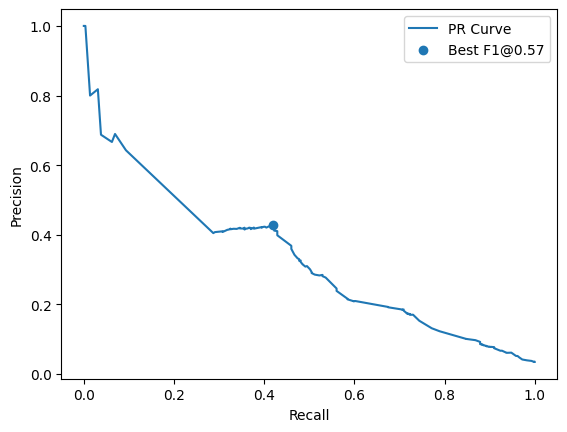

In [31]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-12)
best_idx   = np.argmax(f1_scores)
best_thresh = thresholds[best_idx]
best_f1     = f1_scores[best_idx]

print(f"Optimal threshold: {best_thresh:.3f} → F1 = {best_f1:.3f}")

# Compare default vs optimized
for name, preds in [('Default (0.5)', y_proba>=0.5), ('Optimized', y_proba>=best_thresh)]:
    print(f"\n{name}:")
    print(classification_report(y_test, preds.astype(int), target_names=['No CIN','CIN']))

# Plot PR curve
plt.plot(recalls, precisions, label='PR Curve')
plt.scatter(recalls[best_idx], precisions[best_idx], label=f'Best F1@{best_thresh:.2f}')
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.legend(); plt.show()

The optimal threshold for this model and data was found to be at 0.58. Non-CIN classfication remained strong. From the default model, the CIN precision increased from 0.25 to 0.39, showing this tuned model is much better at identifying CIN cases.

## Feature importance

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Top 10 features by importance (without Attendance):
Gender_Female                                   983
FSM_FSM_Eligible                                870
SEN_No SEN                                      630
Year_Year 8                                     575
Year_Year 7                                     565
Year_Year 9                                     444
Ethnicity_White - White British                 436
Year_Year 10                                    433
Year_Year 11                                    413
Ethnicity_White - Any other White background    320
dtype: int32


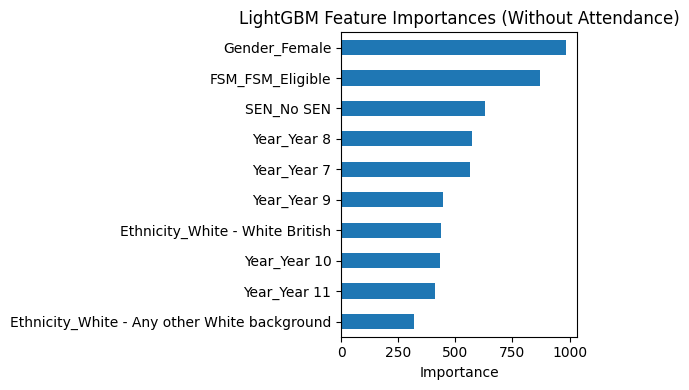

In [32]:
# Reconstruct attrubute list
feature_names = list(ohe.get_feature_names_out(cat_cols))

# Refit evaluated model
lgb_full = LGBMClassifier(
    n_estimators=300,
    is_unbalance=True,
    random_state=42,
    verbose=-1,
    log_level='error'
)
lgb_full.fit(X_train_pre, y_train)

# Sort importance
importances = pd.Series(lgb_full.feature_importances_, index=feature_names)
top10 = importances.sort_values(ascending=False).head(10)

print("Top 10 features by importance (without Attendance):")
print(top10)

# Plot
plt.figure(figsize=(6,4))
top10.sort_values().plot(kind='barh')
plt.title("LightGBM Feature Importances (Without Attendance)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


### Feature Importance Comments

Without attendance the reliance of attributes shifts to a broader mix of the remaining attributes.

Overall, this balanced profile indicated the model is learning from multiple student characteristics not just one single proxy.